<a href="https://colab.research.google.com/github/TeinkBR/1D_harmonic_oscillator/blob/main/6_GNN_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


# Explaining GNN Model Predictions using Captum

In this tutorial we demonstrate how to apply feature attribution methods to graphs. Specifically, we try to find the most important edges for each instance prediction.  

We use the Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

## Loading the dataset

We load the dataset and use 10% of the data as the test split.

In [2]:
# Necessary Imports
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool
from captum.attr import Saliency, IntegratedGradients
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [3]:
import torch
import torch.nn as nn

In [4]:
# Load Dataset
path = '.'
# Instantiate the QM9 dataset
dataset = QM9(path).shuffle()
#dataset = QM9(path)

# Create a DataLoader instance
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualizing the data

We define some utility functions for visualizing the molecules and draw a random molecule.

In [10]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


## Sample visualization

We sample a single molecule from train_dataset and visualize it

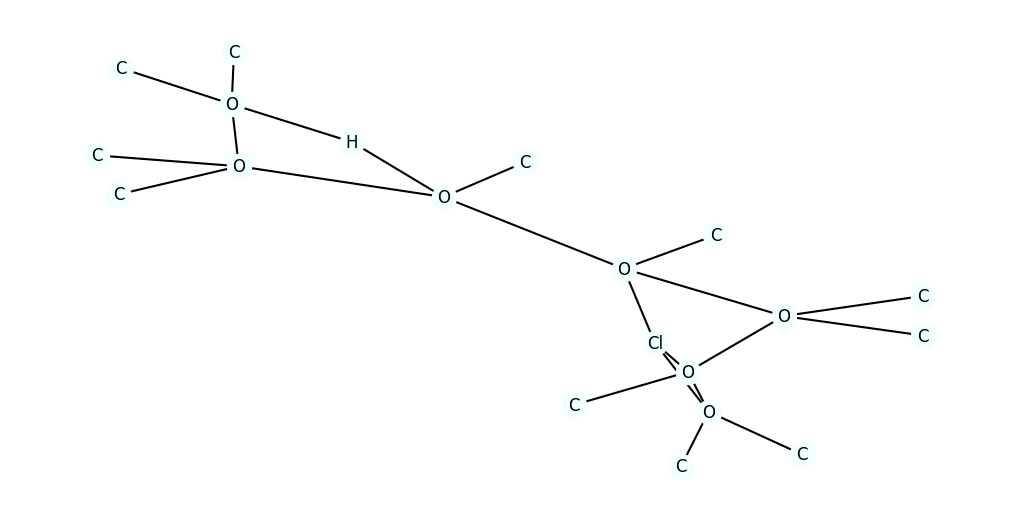

In [11]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

## Training the model

In the next section, we train a GNN model with 5 convolution layers. We use GraphConv which supports `edge_weight` as a parameter. Many convolution layers in Pytorch Geometric supoort this argument.

### Define the model

In [13]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        spin_density_dim = 5  # Replace with the dimension of your spin density states
        self.dim = dim
        self.total_features = num_features + spin_density_dim  # Add spin density features


        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


# Get spin density

In [14]:
# Define the function to get spin density states.
# This is a placeholder; you should replace it with your actual function.
def get_spin_density_states(data):
    return torch.randn((data.x.shape[0], 5))

### Define train and test functions

In [15]:
def train(epoch, criterion):
    model.train()
    loss_all = 0
    for data in train_loader:
        x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
        mini_batch_size = y.size(0)  # Assuming y has shape [N]

        optimizer.zero_grad()

        output = model(x, edge_index, batch)
        print("Debug: Output shape before squeeze: ", output.shape)  # Debug line

        # Reshape to be [N, C]
        output_resized = output.view(mini_batch_size, -1)
        print("Debug: Output shape after resize: ", output_resized.shape)  # Debug line

        loss = criterion(output_resized, y)  # y should have shape [N]
        loss.backward()
        optimizer.step()

        loss_all += loss.item() * data.num_graphs

    return loss_all / len(train_loader.dataset)


In [21]:
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        print(f'Data Shape: {data.y.shape}')  # Debug line to check the shape of data.y

        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        print(f'Output Shape: {output.shape}')  # Debug line to check the shape of output
        '''
        pred = output.max(dim=1)[1]
        print(f'Pred Shape: {pred.shape}')  # Debug line to check the shape of pred

        correct += pred.eq(data.y).sum().item()
        '''

        # Assuming `output` is your network's output
        pred = (torch.sigmoid(output) > 0.5).float()

        # Count the number of labels that are predicted correctly for each sample
        correct_labels = pred.eq(data.y).sum().item()

        # Increment your correct counter
        correct += correct_labels

    return correct / len(loader.dataset)

from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask


import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


In [17]:
from captum.attr import Saliency, IntegratedGradients
import random
from collections import defaultdict

### Train the model for 100 epochs

The accuracy should be around 80% in the end

In [30]:
# Training Loop and Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()  # or whatever loss function suits your problem
'''
for epoch in range(1, 101):

    loss = train(epoch, criterion)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
'''

"\nfor epoch in range(1, 101):\n\n    loss = train(epoch, criterion)\n    train_acc = test(train_loader)\n    test_acc = test(test_loader)\n    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')\n"

## Explaining the predictions

Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.



In [38]:
# Create an empty list to store entries where t.y meets your condition
filtered_data = []

# Loop through the dataset and append entries to filtered_data if they meet your condition
for t in test_dataset:
    print("Shape of t.y:", t.y.shape)
    print("Contents of t.y:", t.y)
    if t.y[0][0].item() == 0:  # Assuming you're interested in the first column of t.y
        filtered_data.append(t)

# Randomly select an element from filtered_data
data = random.choice(filtered_data)

Streaming output truncated to the last 5000 lines.
Shape of t.y: torch.Size([1, 19])
Contents of t.y: tensor([[ 6.6711e+00,  7.6580e+01, -5.4559e+00, -2.9388e-01,  5.1620e+00,
          1.1242e+03,  3.1038e+00, -1.2250e+04, -1.2250e+04, -1.2250e+04,
         -1.2251e+04,  3.1700e+01, -6.5064e+01, -6.5420e+01, -6.5780e+01,
         -6.0581e+01,  2.1309e+00,  1.8402e+00,  9.8834e-01]])
Shape of t.y: torch.Size([1, 19])
Contents of t.y: tensor([[ 2.0973e+00,  7.6620e+01, -5.5919e+00, -4.6804e-01,  5.1239e+00,
          1.0200e+03,  3.4816e+00, -1.0906e+04, -1.0906e+04, -1.0906e+04,
         -1.0907e+04,  2.6156e+01, -7.4079e+01, -7.4516e+01, -7.4901e+01,
         -6.9305e+01,  3.6172e+00,  1.6073e+00,  1.1404e+00]])
Shape of t.y: torch.Size([1, 19])
Contents of t.y: tensor([[ 2.4426e+00,  8.1510e+01, -6.5525e+00,  1.5864e+00,  8.1389e+00,
          1.1864e+03,  5.5184e+00, -1.1576e+04, -1.1576e+04, -1.1576e+04,
         -1.1577e+04,  4.0604e+01, -9.1379e+01, -9.1973e+01, -9.2538e+01,
    

Finally we take a random sample from the test dataset and run the explanation methods. For a simpler visualization, we make the graph undirected and merge the explanations of each edge in both directions.

It is known that NO2 substructure makes the molecules mutagenic in many cases and you can verify this by the model explanations.

Mutagenic molecules have label 0 in this dataset and we only sample from those molecules but you can change the code and see the explanations for the other class as well.

In this visualization, edge colors and thickness represent the importance. You can also see the numeric value by passing `draw_edge_labels` to `draw_molecule` function.

As you can see Integrated Gradients tend to create more accurate explanations.

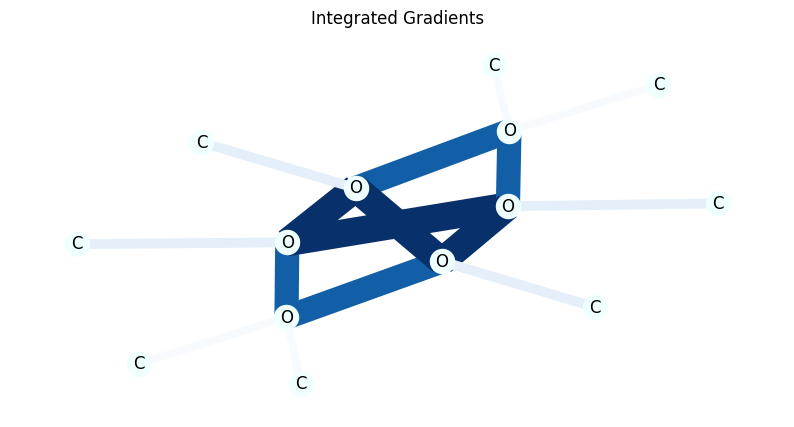

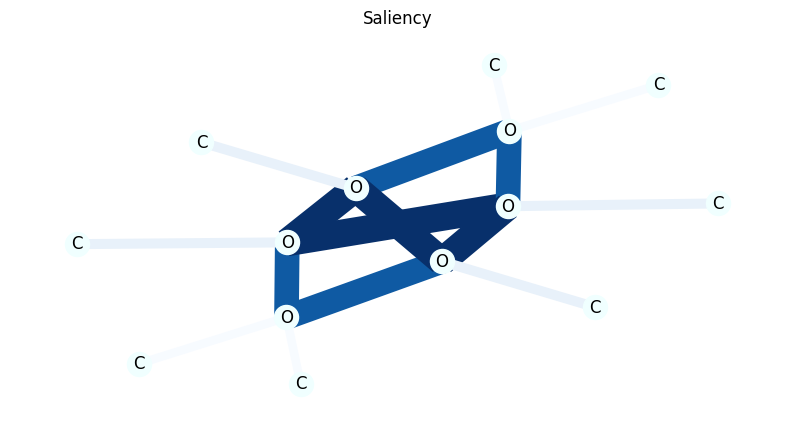

In [39]:
# Attribution

#data = random.choice([t for t in test_dataset if t.y.item() == 0])  # Ensuring target class is consistent
mol = to_molecule(data)
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)